In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from libs.utils import forceNamingConvention

In [2]:
# set main paths
path = Path('/Users/jonniebarnsley/data/phd/Control')
csv = pd.read_csv('data/PPE.csv') # summary csv with ppe values and sea level contribution for each run

In [9]:
def load(variable: str, at_time: int) -> dict:

    '''
    Opens all netcdfs for a given variable and extracts the 2-d spatial data at a given time value. Returns
    a list of DataArrays which can then be further manipulated, e.g. to find the ensemble mean.

    inputs:
     - variable: the variable name, e.g. thickness
     - at_time: the simulation time to plot (30 for first timestep and 9990 for last timestep)

    output:
     - data: a list of xarray DataArrays, with each element being one run in the ensemble. 
    '''

    path = Path('/Users/jonniebarnsley/data/phd/pliocene')
    arrays = {}
    variable_dir = path / variable
    files = sorted(variable_dir.iterdir())

    for file in files:
        
        # ignore hidden files if they exist
        if file.name.startswith('.'):
            continue

        dataset = forceNamingConvention(xr.open_dataset(file, engine='netcdf4'))
        array = dataset[variable]
        try:
            array_at_time_t = array.sel(time=at_time).drop_vars('time') # select time and drop time variable from dataarray
            arrays[file.name] = array_at_time_t
        except KeyError:
            print(f'{file.name} has no time coordinate {at_time}. continuing...')
            continue
    
    return arrays

## Thickness

In [10]:
dthk_arrays = [] # list to store thickness change data

init_thk = load('thickness', at_time=30) # initial thickness for each run
final_thk = load('thickness', at_time=9990) # final thickness for each run

# iterate over runs
for filename, final in final_thk.items():
    init = init_thk[filename]
    change_in_thk = final.fillna(0)-init.fillna(0) # fill NaN with 0 to prevent issues (e.g. NaN - float = NaN)
    dthk_arrays.append(change_in_thk)

# concatenate all dataarrays into one big dataarray so we can take the mean and std using xarray's built in methods
dthk = xr.concat(dthk_arrays, dim='run')
mean = dthk.mean(dim='run')
std = dthk.std(dim='run')

# put nans back in for nicer plotting
ensemble_mean_thickness_change = mean.where(mean != 0)
ensemble_std_thickness_change = std.where(std > 0)

Pliocene_run048_cesm_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...


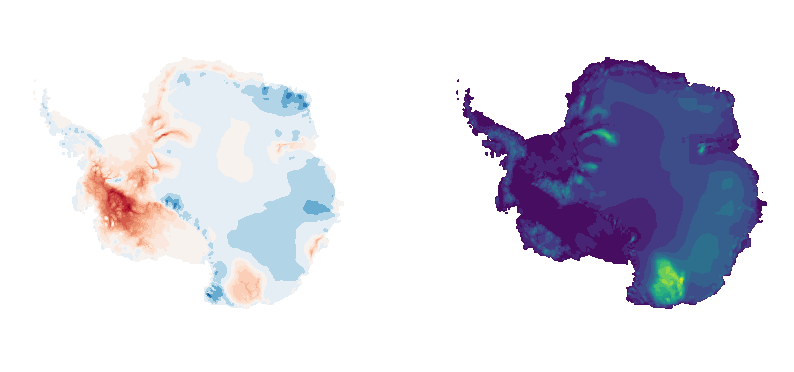

In [11]:
# quick plot to take a look
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

im = ax[0].contourf(ensemble_mean_thickness_change, 20, norm=mpl.colors.TwoSlopeNorm(0), cmap='RdBu')

ax[1].contourf(ensemble_std_thickness_change, 20)

for axis in ax:
    axis.set_axis_off()
    axis.set_aspect('equal')

#fig.colorbar(im, extend='both')

## Grounded Area

In [12]:
# Grounded Area

rhoi = 918  # density of ice
rhoo = 1028 # density of ocean

zbArrays = load('Z_base', 9990).values()
thkArrays = load('thickness', 9990).values()

grounded_area_datasets = []
for zbase, thk in zip(zbArrays, thkArrays):
    grounded_mask = (thk > -zbase*rhoo/rhoi).astype(int) # floatation criteria
    grounded_area_datasets.append(grounded_mask)

ds = xr.concat(grounded_area_datasets, dim='run')
mean = ds.mean(dim='run')
proportion_grounded = mean.where(mean > 0) # get rid of grey background

Pliocene_run048_cesm_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run048_cesm_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...


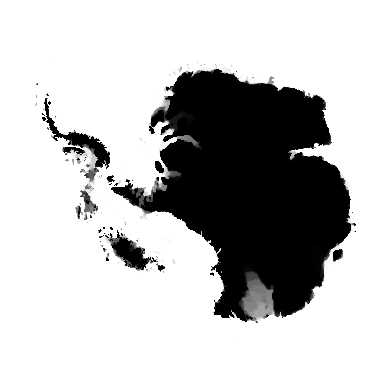

In [13]:
fig, ax = plt.subplots()
ax.pcolormesh(proportion_grounded, cmap='Greys')
ax.set_axis_off()
ax.set_aspect('equal')

## Velocity

In [14]:
speed_datasets = []
xVelArrays = load('xVel', 9990).values()
yVelArrays = load('yVel', 9990).values()
for xvel, yvel in zip(xVelArrays, yVelArrays):
    speed = np.sqrt(xvel**2 + yvel**2)
    speed_datasets.append(speed)

ensemble_mean_speed = xr.concat(speed_datasets, dim='dummy').mean(dim='dummy')
ensemble_std_speed = xr.concat(speed_datasets, dim='dummy').std(dim='dummy')

Pliocene_run048_cesm_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run048_cesm_yVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_yVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_yVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_yVel_0lev.nc has no time coordinate 9990. continuing...


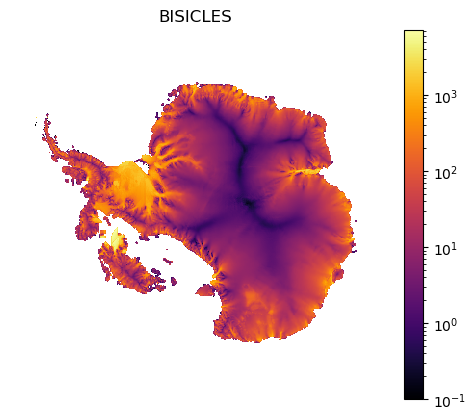

In [15]:
fig, ax = plt.subplots()
im = ax.pcolormesh(ensemble_mean_speed, cmap='inferno', norm=mpl.colors.LogNorm(vmin=0.1))
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('BISICLES')
fig.colorbar(im)

In [17]:
file = xr.open_dataset('/Users/jonniebarnsley/data/MEaSUREs/antarctica_ice_velocity_450m_v2.nc')
file

<xarray.Dataset>
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 ...
    VY            (y, x) float32 ...
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

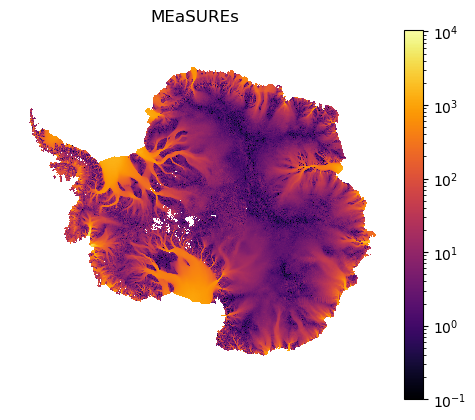

In [18]:
# MEaSUREs InSAR-Based Antarctica Ice Velocity Map
ds = xr.open_dataset('/Users/jonniebarnsley/data/MEaSUREs/antarctica_ice_velocity_450m_v2.nc', chunks='auto')
x_measures = ds.x.values
y_measures = ds.y.values
vx = ds.VX
vy = ds.VY
speed_measures = np.sqrt(vx**2+vy**2)

fig, ax = plt.subplots()
im = ax.pcolormesh(x_measures, y_measures, speed_measures, norm=mpl.colors.LogNorm(vmin=0.1), cmap='inferno')
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('MEaSUREs')
fig.colorbar(im)

In [19]:
# MEaSUREs has 450m resolution compared to BISICLES 16km

print(
    'MEaSUREs',
    speed_measures.shape, 
    f'x: {min(x_measures)} to {max(x_measures)}',
    f'y: {min(y_measures)} to {max(y_measures)}',
    '', sep='\n'
)

# Compare with BISICLES
x_bisicles = ensemble_mean_speed.x.values
y_bisicles = ensemble_mean_speed.y.values

print(
    'BSICLES',
    ensemble_mean_speed.shape, 
    f'x2: {min(x_bisicles)} to {max(x_bisicles)}',
    f'y2: {min(y_bisicles)} to {max(y_bisicles)}',
    '', sep='\n'
)

MEaSUREs
(12445, 12445)
x: -2800000.0 to 2799800.0
y: -2799800.0 to 2800000.0

BSICLES
(384, 384)
x2: 8000.0 to 6136000.0
y2: 8000.0 to 6136000.0



In [20]:
# Add 450m grid squares to MEaSUREs until it has the same extent as BISICLES
num_to_pad = round((max(x_bisicles-8000)/2 - max(x_measures+100))/450) # ± adjustments to center datasets on 0
padded = np.pad(speed_measures, num_to_pad, mode='constant', constant_values=np.nan)
Nx, Ny = padded.shape

# use xarray's interp method to interpolate MEaSUREs onto BISICLES grid
padded_ds = xr.DataArray(
    padded, 
    coords={
        'x': np.linspace(max(x_bisicles), min(x_bisicles), Nx), 
        'y': np.linspace(min(y_bisicles), max(y_bisicles), Ny)
        }, 
    dims=('x', 'y')
    )
measures_on_bisicles_grid = padded_ds.interp(coords = ensemble_mean_speed.coords)
speed_anomaly = ensemble_mean_speed - measures_on_bisicles_grid

In [21]:
measures_on_bisicles_grid

<xarray.DataArray (x: 384, y: 384)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 8e+03 2.4e+04 4e+04 ... 6.104e+06 6.12e+06 6.136e+06
  * y        (y) float64 8e+03 2.4e+04 4e+04 ... 6.104e+06 6.12e+06 6.136e+06

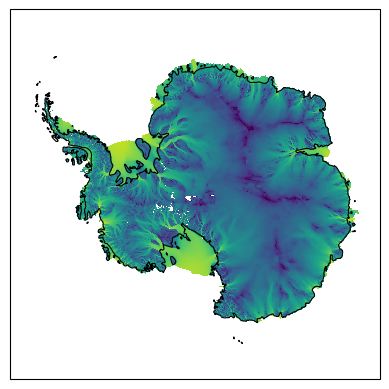

In [36]:
from libs.customplots import spatialPlot

spatialPlot(measures_on_bisicles_grid, norm=mpl.colors.LogNorm(vmin=0.1))

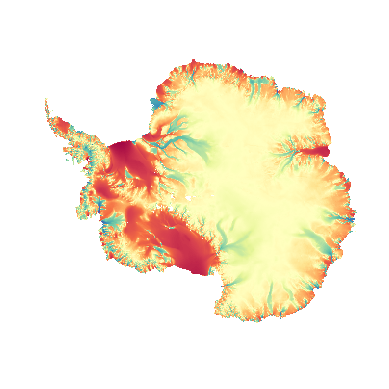

In [13]:
fig, ax = plt.subplots()

ax.pcolormesh(speed_anomaly, norm = mpl.colors.SymLogNorm(10), cmap='Spectral_r')
ax.set_aspect('equal')
ax.set_axis_off()

## Main Plot

FileNotFoundError: [Errno 2] No such file or directory: '/plots/pdf/spatialdata.pdf'

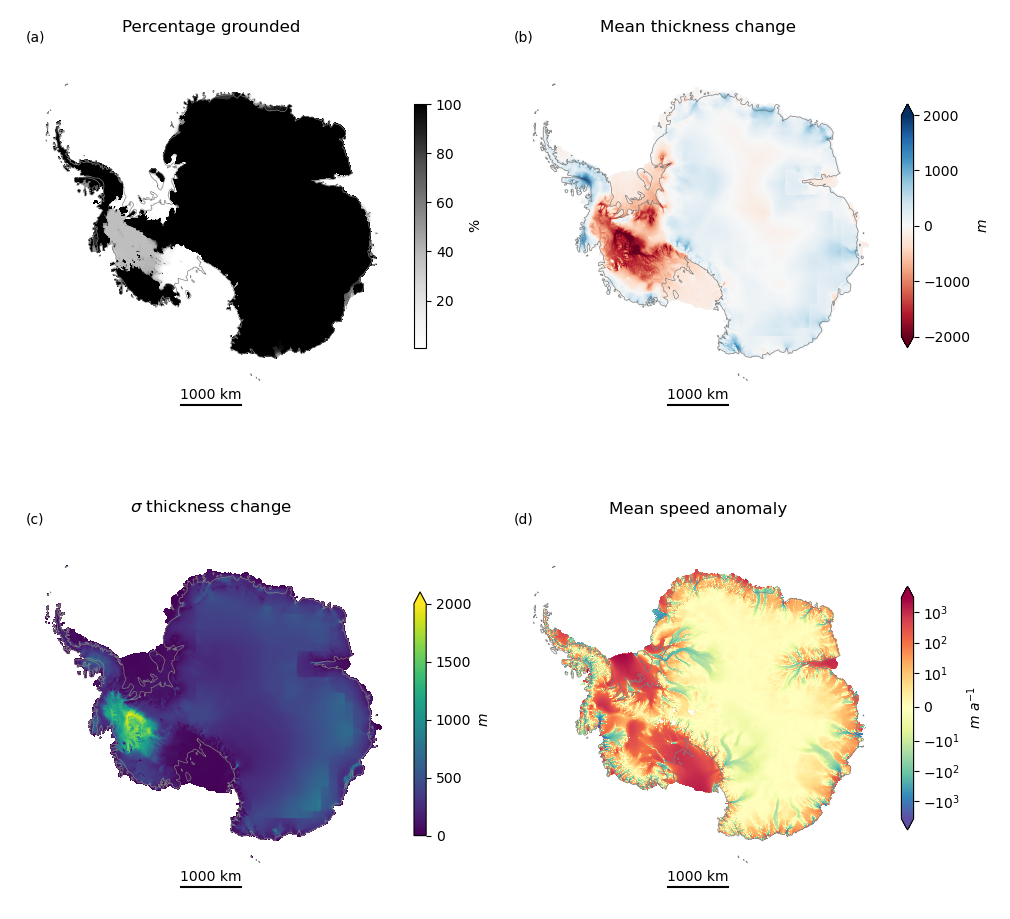

In [23]:
# mpl settings
font = {
    'size': 10,
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans']
    }
mathtext = {
    'fontset': 'dejavusans'
}
savefig = {
    'bbox' : 'tight',
    'pad_inches': 0.2
}
mpl.rc('font', **font)
mpl.rc('mathtext', **mathtext)
mpl.rc('savefig', **savefig)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize = (10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# centre coordinates on 0
mid = max(x_bisicles)/2 # middle of axis for plotting anchors
x = x_bisicles-mid
y = y_bisicles-mid
d = 500_000 # 500 km

# choose axes for plots

grounded_ax = axes[0][0]
mean_tkh_ax = axes[0][1]
std_tkh_ax = axes[1][0]
velocity_ax = axes[1][1]

# plot images
kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
im1 = mean_tkh_ax.pcolormesh(x, y, ensemble_mean_thickness_change, cmap='RdBu', vmin=-2000, vmax=2000, transform=ccrs.Stereographic(**kw))
im2 = std_tkh_ax.pcolormesh(x, y, ensemble_std_thickness_change, cmap='viridis', vmin=0, vmax=2000, transform=ccrs.Stereographic(**kw))
im3 = grounded_ax.pcolormesh(x, y, proportion_grounded*100, cmap='Greys', transform=ccrs.Stereographic(**kw))
im4 = velocity_ax.pcolormesh(x, y, speed_anomaly, cmap='Spectral_r', norm=mpl.colors.SymLogNorm(10), transform=ccrs.Stereographic(**kw))

# axes settings
for ax, letter in zip(axes.flatten(), ['(a)', '(b)', '(c)', '(d)']):
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.plot((-d, +d), (min(y)+100_000, min(y)+100_000), color='black')
    ax.text(0, min(y)+200_000, '1000 km', ha='center', size=10)
    ax.coastlines('50m', lw=0.5, color='grey')
    ax.text(min(x), max(y), letter)

# colorbars
frac = 0.03
pad = 0.03
loc = 'right'
cbar1 = plt.colorbar(im1, ax=mean_tkh_ax, location=loc, pad=pad, fraction=frac, label='$m$', extend='both', ticks=[-2000, -1000, 0, 1000, 2000])
cbar2 = plt.colorbar(im2, ax=std_tkh_ax, location=loc, pad=pad, fraction=frac, label='$m$', extend='max', ticks=[0, 500, 1000, 1500, 2000])
cbar3 = plt.colorbar(im3, ax=grounded_ax, location=loc, pad=pad, fraction=frac, label='%')
cbar4 = plt.colorbar(im4, ax=velocity_ax, location=loc, pad=pad, fraction=frac, label='$m\ a^{-1}$', extend='both')

# axis titles
pad = -0.05
mean_tkh_ax.set_title('Mean thickness change', pad=pad)
std_tkh_ax.set_title('$\sigma$ thickness change', pad=pad)
grounded_ax.set_title('Percentage grounded', pad=pad)
velocity_ax.set_title('Mean speed anomaly', pad=pad)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0)

plt.savefig('plots/pdf/spatialdata.pdf', format='pdf')
plt.savefig('plots/png/spatialdata.png', format='png')

## PCA

In [ ]:
parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']

print('original:', thickness_ds.shape)
factor=4
coarsened = thickness_ds.coarsen(x=factor, y=factor).mean()

N, Nx, Ny = coarsened.shape
print('coarsened:', coarsened.shape)
A = coarsened.values
A = (A-A.mean())/A.std()
A.shape = (N, Nx*Ny)
print('flattened:', A.shape)

for param in reversed(parameters):
    v = csv[param].values
    v = (v-v.mean())/v.std()
    v = v.reshape(-1, 1)
    A = np.concatenate((v, A), axis=1)
print('with params:', A.shape)

original: (120, 384, 384)
coarsened: (120, 96, 96)
flattened: (120, 9216)
with params: (120, 9221)


In [ ]:
C = np.cov(A, rowvar = False)
LAM, E = np.linalg.eig(C)

eof1 = np.reshape(np.real(E[5:,0]), (Ny,Nx))
eof2 = np.reshape(np.real(E[5:,1]), (Ny,Nx))

pc1  = np.dot(A, np.real(E[:,0]))
pc1 = (pc1 - pc1.mean())/pc1.std()
pc2  = np.dot(A, np.real(E[:,1]))
pc2 = (pc2 - pc2.mean())/pc2.std()

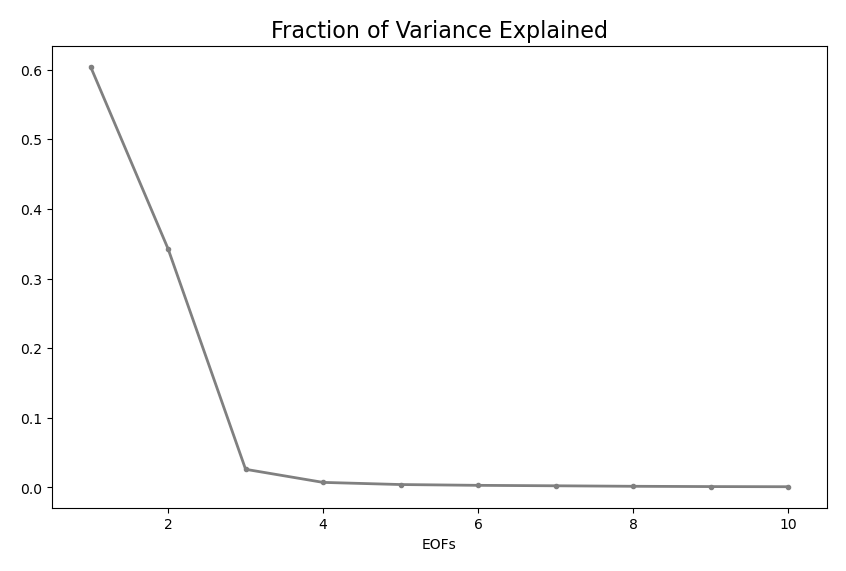

In [ ]:
plt.figure(figsize=(10,6))

# plot fraction of variance explained by first 10 eigenvectors using the eigenvalues
plt.plot(np.arange(1,np.size(LAM[:10])+1.),LAM[:10] / LAM.sum(),'.-',color='gray',linewidth=2)
plt.xlim(0.5, 10.5)

# add labels, title, etc.
plt.title('Fraction of Variance Explained',fontsize=16)
plt.xlabel('EOFs')

plt.savefig('../plots/screeplot.svg', format='svg')

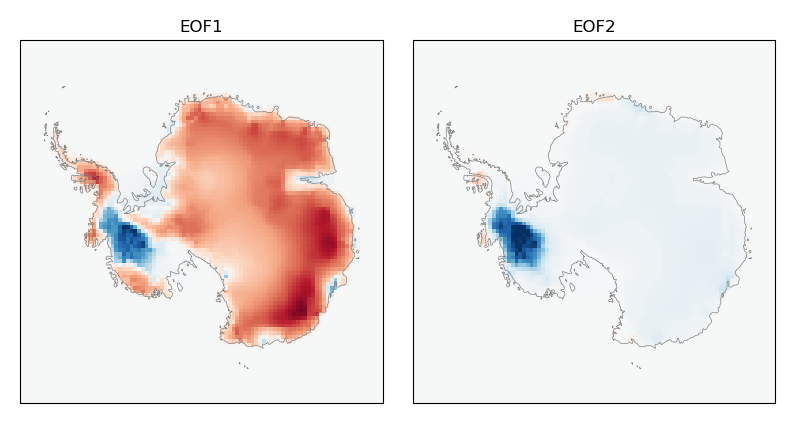

In [ ]:
eofx = -xs.coarsen(x=4).mean()
eofy = ys.coarsen(y=4).mean()

eoflat, eoflon = xy2ll(eofx+3068000, eofy-3068000, -1, -90, 71)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# eof1 = np.where(coarse_mask == True, np.nan, eof1)
# eof2 = np.where(coarse_mask == True, np.nan, eof2)

for ax in axes:
    # ax.set_axis_off()
    ax.set_aspect('equal')
    ax.coastlines(color='grey', lw=0.5)

im = axes[0].pcolormesh(eoflon, eoflat, eof1, transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-0.04, vmax=0.04)
#axes[0].pcolormesh(border, cmap='binary')
im2 = axes[1].pcolormesh(eoflon, eoflat, eof2, transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-0.1, vmax=0.1)

axes[0].set_title('EOF1')
axes[1].set_title('EOF2')

# fig.colorbar(im, ax=axes[0], fraction=0.04, ticks=np.arange(-0.1, 0.15, 0.05))
# fig.colorbar(im2, ax=axes[1], fraction=0.04, ticks=np.arange(-0.1, 0.15, 0.05))

fig.tight_layout()
plt.savefig('../plots/eofs.svg', format='svg')
plt.savefig('../plots/eofs.png', format='png')

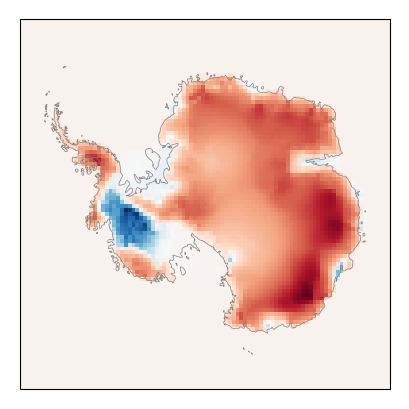

In [ ]:
eofx = -xs.coarsen(x=4).mean()
eofy = ys.coarsen(y=4).mean()

eoflat, eoflon = xy2ll(eofx+3068000, eofy-3068000, -1, -90, 71)

fig = plt.figure()
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.pcolormesh(eoflon, eoflat, eof1, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines(color='grey', lw=0.5)

In [ ]:
loadings = pd.DataFrame({
    'PC1': np.real(E[:5, 0]*np.sqrt(np.real(LAM[0]))), 
    'PC2': np.real(E[:5, 1]*np.sqrt(np.real(LAM[1])))}, 
    index=parameters
    )
loadings

PC1       PC2
gamma0  0.352510  0.698776
UMV    -0.104686 -0.036045
LRP     0.062802  0.014208
PDDi   -0.098257  0.195584
WeertC -0.952485  0.137563

In [ ]:
LAM[:10] / LAM.sum()

array([0.60413508-8.54090101e-33j, 0.34259203-4.84336159e-33j,
       0.02610116-3.69002614e-34j, 0.00729642-1.03152441e-34j,
       0.00421292-5.95597093e-35j, 0.0030695 -4.33948098e-35j,
       0.00242103-3.42270674e-35j, 0.00170797-2.41463143e-35j,
       0.00128934-1.82279412e-35j, 0.00108273-1.53070557e-35j])

In [ ]:
df = pd.DataFrame({
    'PC1'   : pc1, 
    'PC2'   : pc2, 
    'gamma0' : csv['gamma0'].values
    })
df.head()

PC1       PC2         gamma0
0  0.317628 -0.960927    9618.882299
1  1.625094  0.211881  159188.541441
2  1.349357  0.578218  159188.541441
3  0.270647  1.402885  471264.291708
4 -0.179099  1.831365  159188.541441

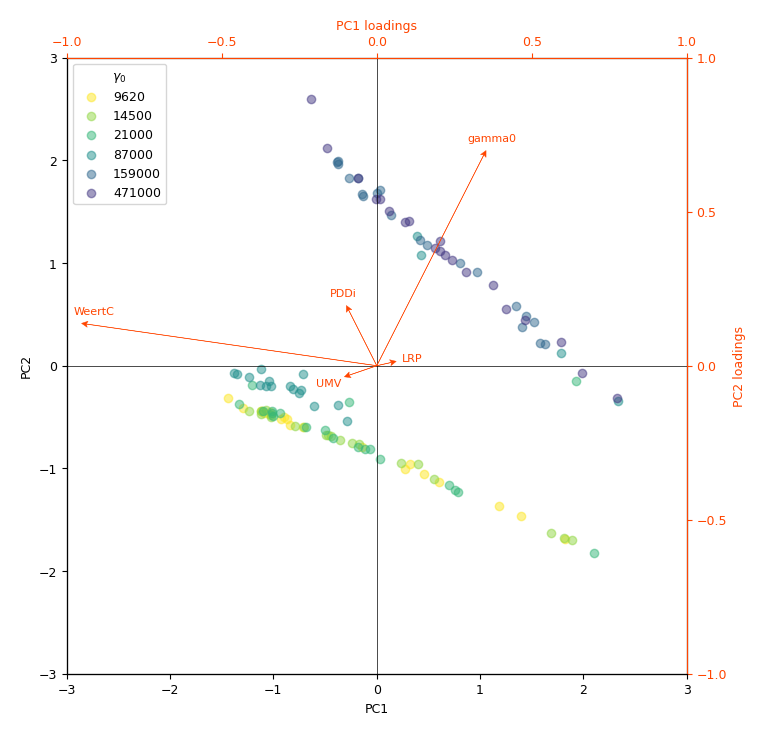

In [ ]:
import math

font = {'size': 9}
mpl.rc('font', **font)

def round_to_three_significant_figures(number):
    if number != 0:
        return int(round(number, 3 - int(math.floor(math.log10(abs(number)))) - 1))
    else:
        return 0.0

unique_gamma_values = sorted(csv['gamma0'].unique())
colors = mpl.cm.viridis_r([i / len(unique_gamma_values) for i in range(len(unique_gamma_values))])
gamma_color_map = {gamma_value: colors[i] for i, gamma_value in enumerate(unique_gamma_values)}

fig, ax = plt.subplots(figsize = (8, 8))

by_model = df.groupby('gamma0')

for gamma0, group in by_model:
    ax.scatter(group['PC1'], group['PC2'], alpha=0.5, label=round_to_three_significant_figures(gamma0), color=gamma_color_map[gamma0])
ax.legend(loc='upper left', title='$\gamma_0$')

ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.hlines(0, -3, 3, lw=0.5, color='black')
ax.vlines(0, -3, 3, lw=0.5, color='black')

adjust = {
    'gamma0'   : (0.02, 0.03),
    'LRP'      : (0.05, 0),
    'UMV'      : (-0.05, -0.03),
    'PDDi'     : (-0.01, 0.03),
    'WeertC'   : (0.04, 0.03)
    }

load_color='orangered'
ax2 = ax.twinx()
ax2.tick_params(axis='both', colors=load_color)
ax2.set_ylabel('PC2 loadings', color=load_color)
ax2 = ax2.twiny()
ax2.tick_params(axis='both', colors=load_color)

ax2.set_xticks([-1, -.5, 0, .5, 1])
ax2.set_yticks([-1, -.5, 0, .5, 1])
ax2.set_xlabel('PC1 loadings', color=load_color)
ax2.spines['right'].set_color(load_color)
ax2.spines['top'].set_color(load_color)

for param in parameters:
    coords=loadings.loc[loadings.index == param]
    dx = float(coords['PC1'].iloc[0])
    dy = float(coords['PC2'].iloc[0])
    ax, ay = adjust[param]
    ax2.arrow(0, 0, dx, dy, 
              lw=0.3,
              length_includes_head=True,
              head_width = 0.02,
              head_length=0.02,
              color=load_color,
              overhang=0.2)
    ax2.text(dx+ax, dy+ay, param, ha='center', size=8, color=load_color)

ax2.set_xlim((-1, 1))
ax2.set_ylim((-1, 1))

plt.savefig('../plots/biplot.svg', format='svg')
plt.savefig('../plots/biplot.png', format='png')

0 0
0 1
1 0
1 1
2 0
2 1


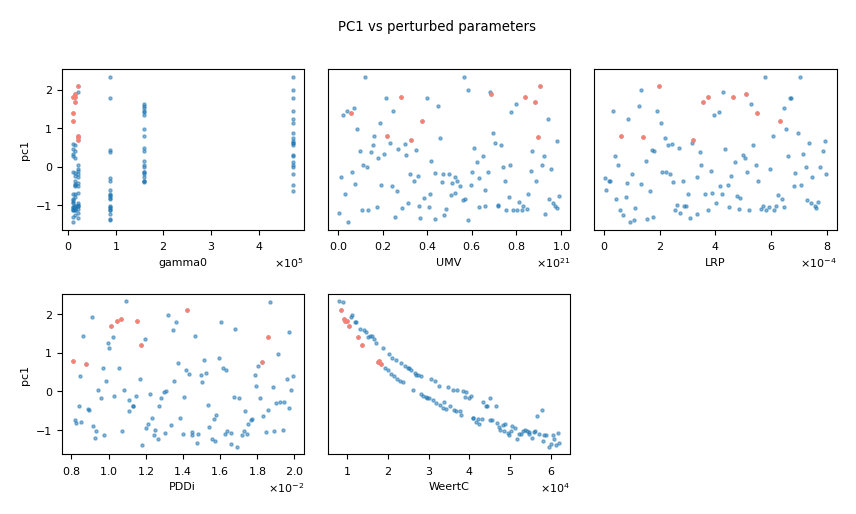

In [ ]:
from itertools import product

font = {'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']
weird_runs = [20, 34, 52, 62, 70, 74, 78, 87, 103, 114]
weird_runs = np.array(weird_runs)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))
for param, ax in zip(parameters, axes.flatten()):
    y = pc1
    x = csv[param].values
    ax.scatter(x, y, s=5, alpha=0.5)
    ax.scatter(x[weird_runs-1], y[weird_runs-1], c='salmon', s=5)
    ax.set_xlabel(param)

    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    ax.xaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', scilimits=(-2, 2))

for i, j in product(range(3), range(2)):
    print(i, j)
    if i == 0:
        axes[j][i].set_ylabel('pc1')
    else:
        axes[j][i].tick_params(axis='y', which='both', left=False, labelleft=False)

fig.suptitle('PC1 vs perturbed parameters')
axes[1][2].set_axis_off()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.savefig('../plots/pc1regression.png', format='png')

0 0
0 1
1 0
1 1
2 0
2 1


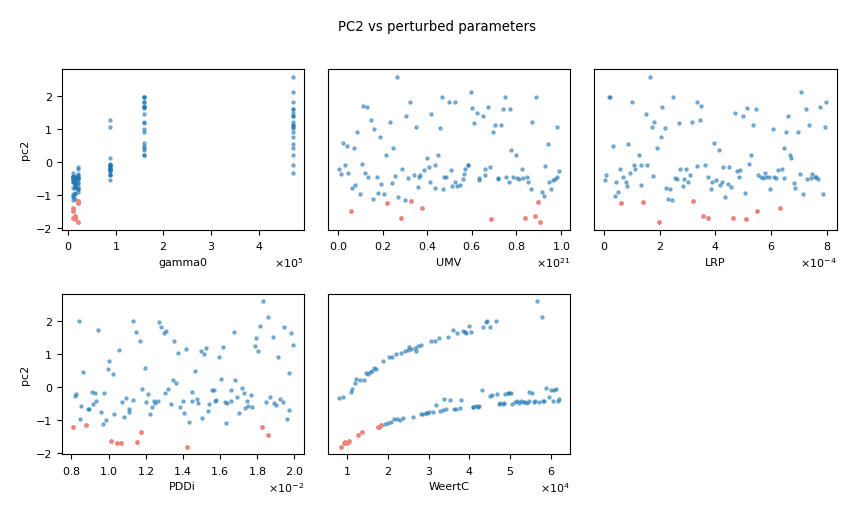

In [191]:
parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))
for param, ax in zip(parameters, axes.flatten()):
    y = pc2
    x = csv[param].values
    ax.scatter(x, y, s=5, alpha=0.5)
    ax.scatter(x[weird_runs-1], y[weird_runs-1], c='salmon', s=5)

    ax.set_xlabel(param)
    #ax.set_ylabel('pc2')

    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    ax.xaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', scilimits=(-2, 2))

for i, j in product(range(3), range(2)):
    print(i, j)
    if i == 0:
        axes[j][i].set_ylabel('pc2')
    else:
        axes[j][i].tick_params(axis='y', which='both', left=False, labelleft=False)


fig.suptitle('PC2 vs perturbed parameters')
axes[1][2].set_axis_off()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.savefig('../plots/pc2regression.png', format='png')

## Basal Thickness Source, Thickness, and gamma0

There is an unusual relationship in the ensemble between gamma0 and west Antarctic mass loss - high gamma0 leads to a more stable WAIS, which is the opposite of what we expect. We investigate this more here.

In [21]:
ds = xr.open_dataset('/Users/jonniebarnsley/data/phd/Control/basalThicknessSource/run004_control_basalThicknessSource_0lev.nc')
ds

<xarray.Dataset>
Dimensions:               (t: 333, x: 384, y: 384)
Coordinates:
  * t                     (t) int64 30 60 90 120 150 ... 9900 9930 9960 9990
  * x                     (x) float64 8e+03 2.4e+04 4e+04 ... 6.12e+06 6.136e+06
  * y                     (y) float64 8e+03 2.4e+04 4e+04 ... 6.12e+06 6.136e+06
Data variables:
    basalThicknessSource  (t, x, y) float64 ...
Attributes:
    units:    mm/yr

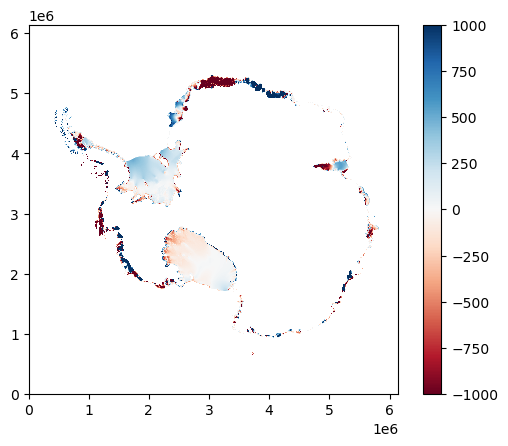

In [22]:
dss = ds.sel(x = slice(1e6, 2e6), y = slice(1.5e6, 3e6))


bts = ds.basalThicknessSource
x = ds.x
y = ds.y

data = bts.mean(dim='t')

#fig = plt.figure()
#ax = plt.axes(projection=ccrs.SouthPolarStereo())

fig, ax = plt.subplots()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
im = ax.pcolormesh(x, y, data, cmap='RdBu', vmin=-1000, vmax=1000)
#im = ax.pcolormesh(x, y, data, cmap='RdBu', vmin=-1000, vmax=1000, transform=ccrs.Stereographic(**kw))

ax.set_aspect('equal')
#ax.set_axis_off()
#ax.set_xlim([1e6, 2e6])
#ax.set_ylim([1.5e6, 3e6])

#ax.set_extent([-180, 180, -90, 90])
#ax.coastlines()

fig.colorbar(im)

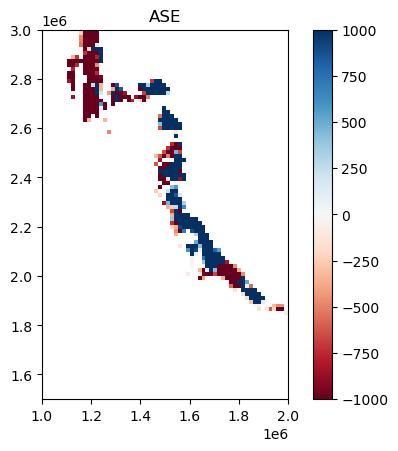

In [23]:
fig, ax = plt.subplots()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
im = ax.pcolormesh(x, y, data, cmap='RdBu', vmin=-1000, vmax=1000)
#im = ax.pcolormesh(x, y, data, cmap='RdBu', vmin=-1000, vmax=1000, transform=ccrs.Stereographic(**kw))

ax.set_aspect('equal')
#ax.set_axis_off()
ax.set_xlim([1e6, 2e6])
ax.set_ylim([1.5e6, 3e6])
ax.set_title('ASE')

#ax.set_extent([-180, 180, -90, 90])
#ax.coastlines()

fig.colorbar(im)

#### Thickness vs gamma0

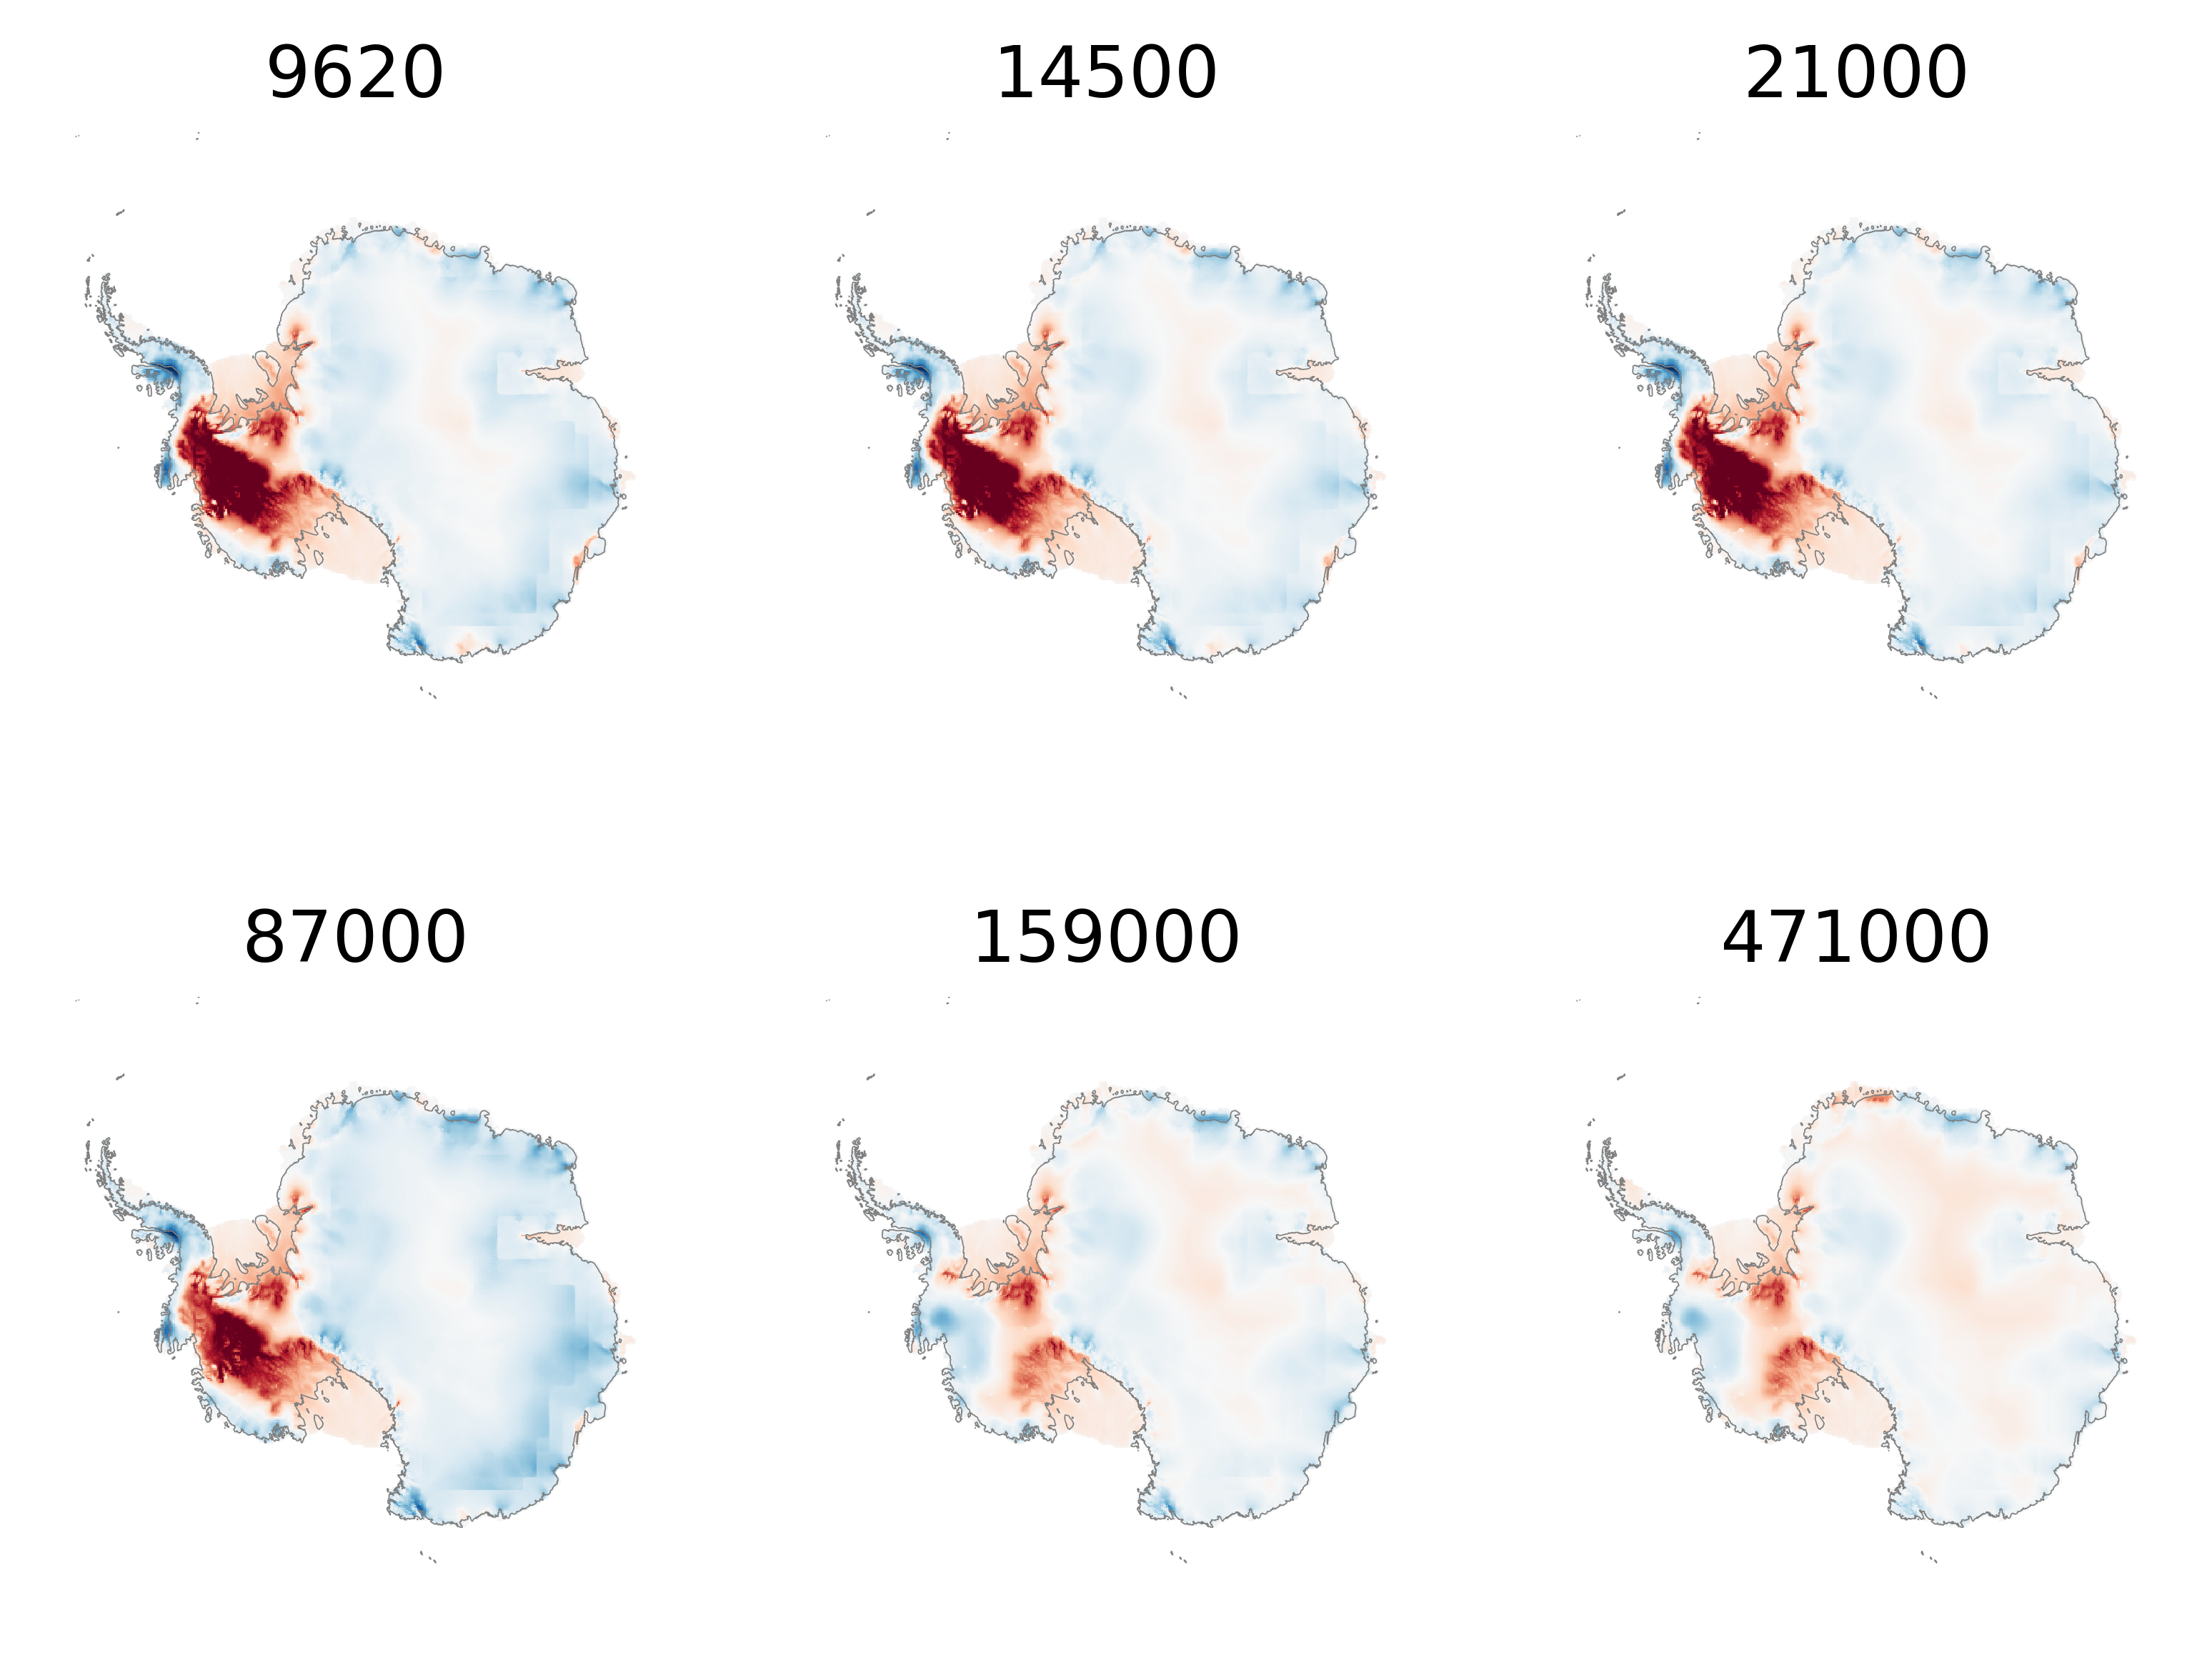

In [24]:
from libs.utils import round_sig_figs

ppe = pd.read_csv('data/ppe.csv')
gamma0 = ppe['gamma0'].values
withgamma = thickness_ds.assign_coords(dummy=gamma0)
grouped = withgamma.groupby('dummy')

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
fig, axes = plt.subplots(ncols=3, nrows=2, dpi=600, subplot_kw={'projection': ccrs.SouthPolarStereo()})

for ax, (g0, ds) in zip(axes.flatten(), grouped):

    data = ds.mean(dim=('dummy'))
    ax.pcolormesh(x-max(x)/2, y-max(y)/2, data.where(data != 0), cmap='RdBu', vmin=-2000, vmax=2000, transform=ccrs.Stereographic(**kw))
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(int(round_sig_figs(g0, 3)))
    ax.coastlines('10m', lw=0.2, color='grey')

#### Basal melt vs gamma0

In [25]:
home = Path(path)
files = home / 'basalThicknessSource'

basalThicknessSource_datasets = [xr.open_dataset(file, engine='netcdf4').mean(dim='t') for file in sorted(files.iterdir())]

bthks_concatenated = xr.concat(basalThicknessSource_datasets, dim='gamma0')
bthks_withcoords = bthks_concatenated.assign_coords(gamma0=gamma0)
bthks_grouped = bthks_withcoords.groupby('gamma0')

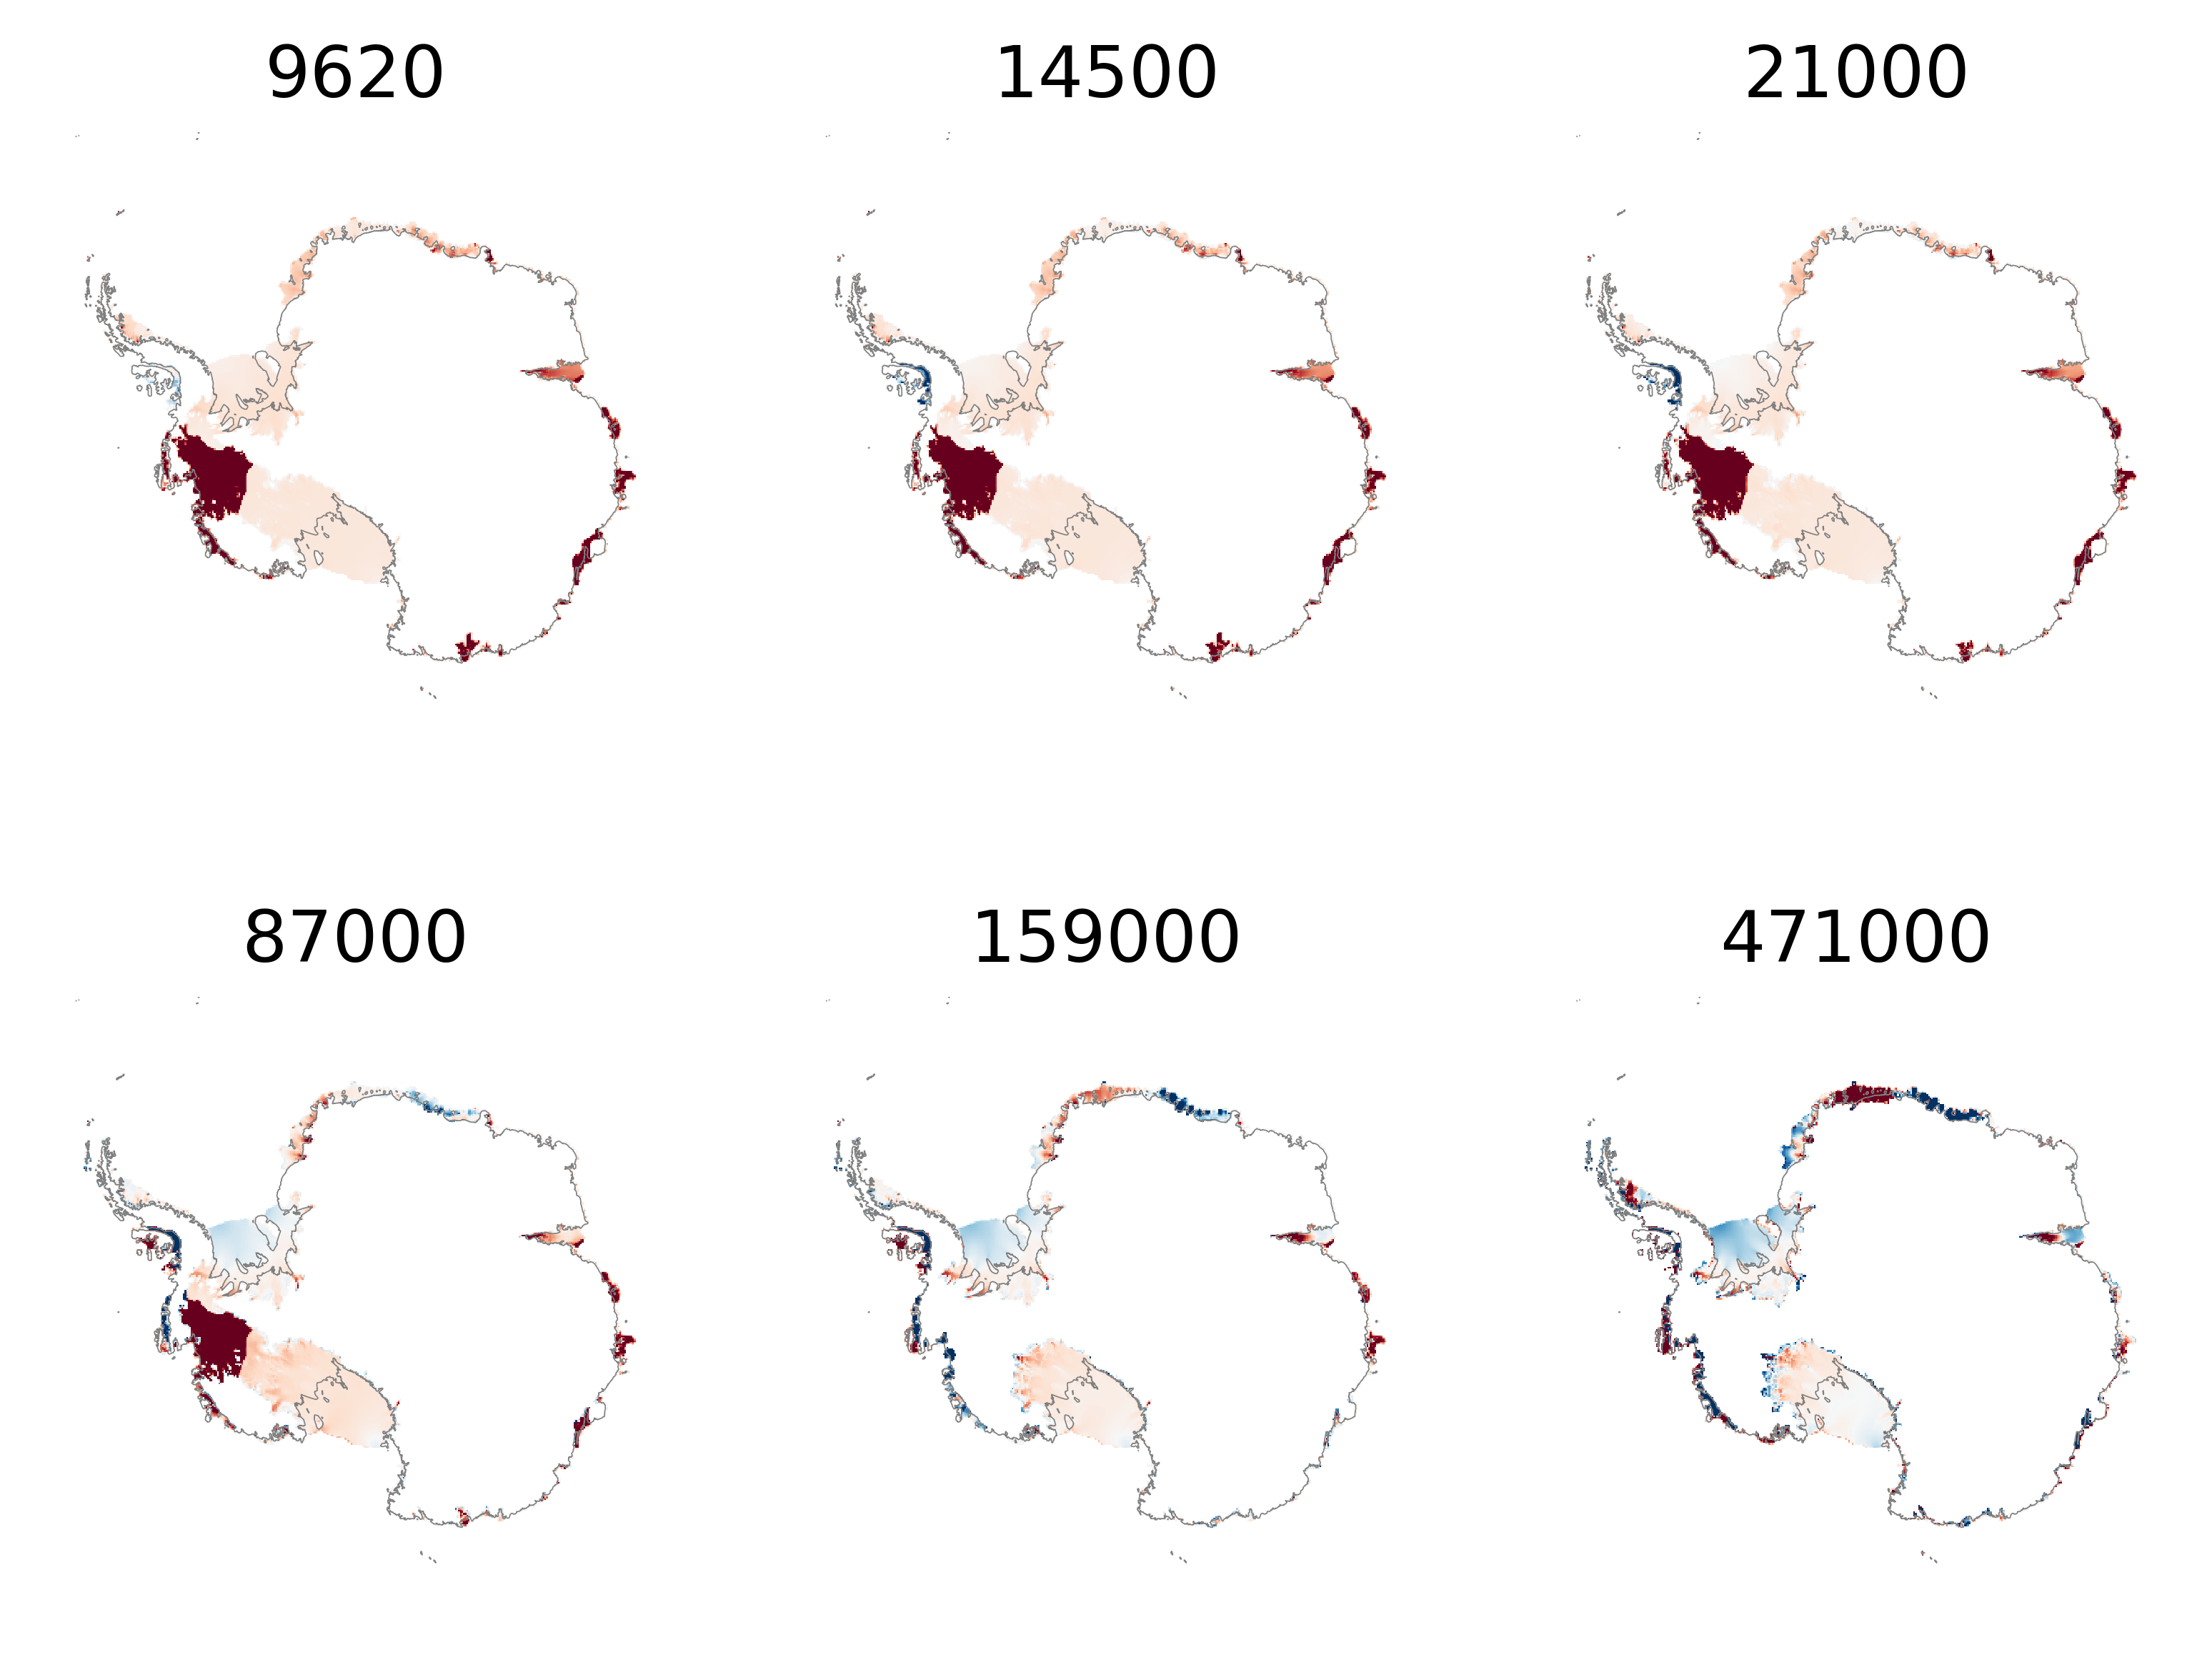

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=2, dpi=600, subplot_kw={'projection': ccrs.SouthPolarStereo()})

for ax, (g0, ds) in zip(axes.flatten(), bthks_grouped):

    data = ds.mean(dim=('gamma0'))
    kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
    im = ax.pcolormesh(
        x - x.max()/2, 
        y - y.max()/2, 
        data.basalThicknessSource, 
        cmap='RdBu', 
        vmin=-1000, 
        vmax=1000, 
        transform = ccrs.Stereographic(**kw)
        )
    ax.coastlines(resolution='10m', lw=0.2, color='grey')
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(int(round_sig_figs(g0, 3)))
    

#fig.colorbar(im)

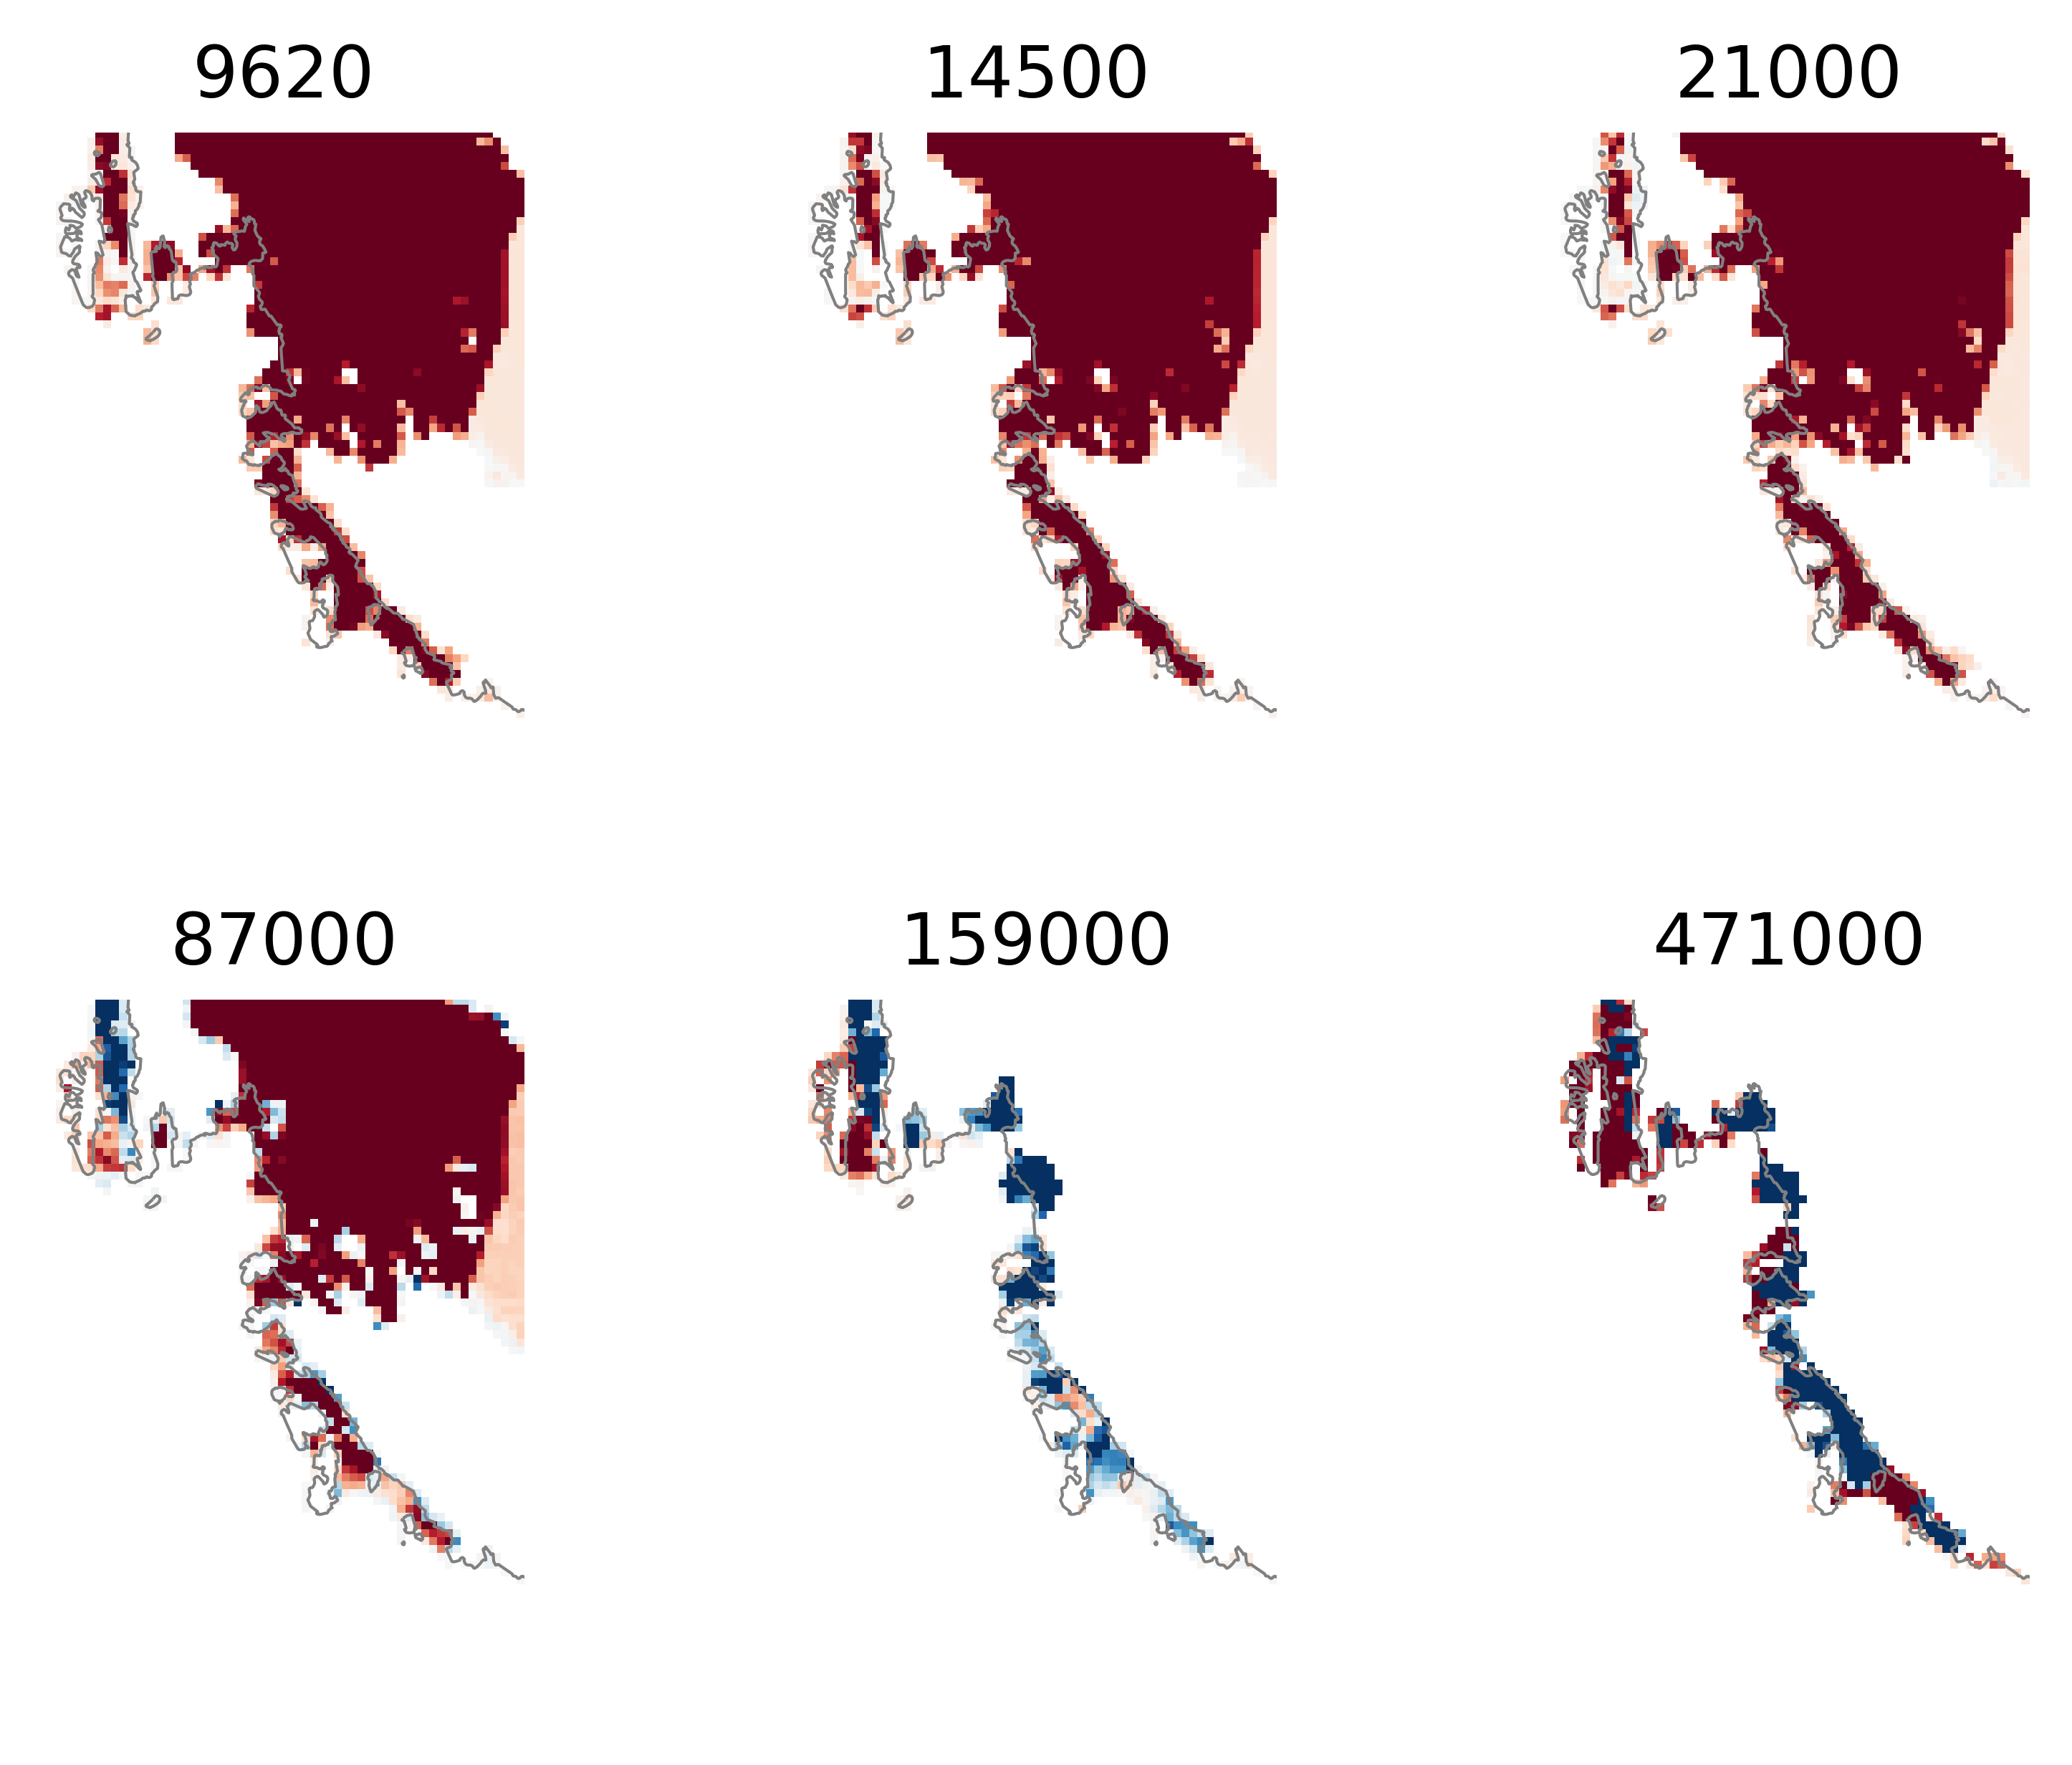

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=2, dpi=600, subplot_kw={'projection': ccrs.SouthPolarStereo()})

for ax, (g0, ds) in zip(axes.flatten(), bthks_grouped):

    data = ds.mean(dim=('gamma0'))
    im = ax.pcolormesh(
        x-x.max()/2, 
        y-y.max()/2, 
        data.basalThicknessSource, 
        cmap='RdBu', 
        vmin=-1000, 
        vmax=1000,
        transform = ccrs.Stereographic(**kw)
        )
    ax.coastlines(resolution='10m', lw=0.5, color='grey')

    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(int(round_sig_figs(g0, 3)))

    ax.set_xlim([1e6-x.max()/2, 2e6-y.max()/2])
    ax.set_ylim([1.5e6-x.max()/2, 3e6-y.max()/2])

In [36]:
data = Path('/Users/jonniebarnsley/data/phd/Control/basalThicknessSource/')
run001 = xr.open_dataset(data / 'run002_control_basalThicknessSource_0lev.nc')

bts = run001.basalThicknessSource
x = run001.x
y = run001.y

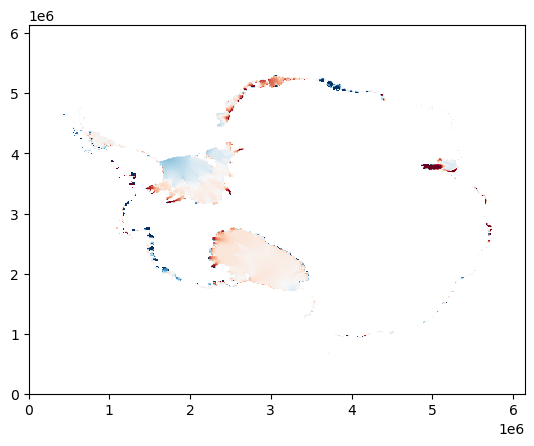

In [41]:
plt.pcolormesh(x, y, bts.isel(t=300), cmap='RdBu', vmin=-1000, vmax=1000)

In [8]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

filename = 'run002_control_activeBasalThicknessSource_0lev.nc'

# load netcdf
dir = '/Users/jonniebarnsley/Desktop'
filepath = os.path.join(dir, filename)
ds = xr.open_dataset(filepath)

x=ds.x
y=ds.y
t=ds.t

fig, ax = plt.subplots(figsize=(8, 5))

ax.set_aspect('equal')

def update(frame):

    '''
    Updates the figure at each frame with the appropriate thickness data
    and point location.
    '''

    subsetted_ds = ds.sel(t=frame)
    abts = subsetted_ds.activeBasalThicknessSource

    # continent 
    ax.clear()
    plot = ax.pcolormesh(x, y, abts, shading='auto', cmap='RdBu', vmin=-1000, vmax=1000)
    ax.set_title(f'year = {frame}')
    ax.set_axis_off()
    ax.set_xlim([1e6, 2e6])
    ax.set_ylim([1.5e6, 3e6])

    return plot,

ani = animation.FuncAnimation(
    fig, 
    update, 
    frames = np.arange(30, 10020, 30), 
    blit=True
    )

writervideo = animation.FFMpegWriter(fps=30)
ani.save(f'/Users/jonniebarnsley/Desktop/activeBasalThicknessSource_ASE.mp4', writer=writervideo)
plt.close(fig)